In [15]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

from matplotlib.collections import LineCollection
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')
neural_data = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').neural, dtype=torch.float32)
labels = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').continuous_index.numpy(), dtype=torch.float32)




# Define the ConvNet with VAE-like architecture
class ConvNetVAE(nn.Module):
    def __init__(self, num_features, num_hidden_units, latent_dim):
        super(ConvNetVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=num_hidden_units, kernel_size=5, stride=1, padding=5),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_hidden_units, out_channels=num_hidden_units, kernel_size=5, stride=1, padding=5),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_hidden_units, out_channels=latent_dim, kernel_size=5, stride=1, padding=5),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=num_hidden_units, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=num_hidden_units, out_channels=num_hidden_units, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=num_hidden_units, out_channels=num_features, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1).permute(0, 2, 1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded.squeeze(2), decoded.permute(0, 2, 1).squeeze(1)

# Reconstruction loss definition
def reconstruction_loss(reconstructed, original):
    return F.mse_loss(reconstructed, original)

# DataLoader setup
dataset = TensorDataset(neural_data, labels)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

# Pretrain the VAE model
def pretrain_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0
    for data, _ in loader:
        data = data.to(device)
        optimizer.zero_grad()
        _, reconstructed = model(data)
        loss = reconstruction_loss(reconstructed, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10
model = ConvNetVAE(num_features=120, num_hidden_units=16, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Run pretraining
pretrain_epochs = 200
for epoch in range(pretrain_epochs):
    loss = pretrain_epoch(loader, model, optimizer)
    if (epoch + 1) % 20 == 0:
        print(f"Pretrain Epoch {epoch + 1}, Loss: {loss:.4f}")

# Save the pre-trained encoder model
torch.save(model.encoder.state_dict(), 'encoder_pretrained.pth')

# Load the encoder for contrastive learning
model.encoder.load_state_dict(torch.load('encoder_pretrained.pth'))

# Define the InfoNCE loss function for contrastive learning
def info_nce_loss(features, labels, temperature=1.0, threshold=0.3):
    features = F.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    labels_diff = torch.cdist(labels[:,0].unsqueeze(1), labels[:,0].unsqueeze(1))
    positive_mask = (labels_diff <= threshold).float()
    exp_sim = torch.exp(similarity_matrix / temperature)
    pos_sum = torch.sum(exp_sim * positive_mask, dim=1)
    all_sum = torch.sum(exp_sim, dim=1)
    loss = -torch.log(pos_sum / all_sum + 1e-6)
    return torch.mean(loss)

# Training loop for contrastive learning
def train_contrastive_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        features, _ = model(data)  # Use only encoder outputs
        loss = info_nce_loss(features, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Run contrastive training
contrastive_epochs = 200
for epoch in range(contrastive_epochs):
    loss = train_contrastive_epoch(loader, model, optimizer)
    if (epoch + 1) % 20 == 0:
        print(f"Contrastive Epoch {epoch + 1}, Loss: {loss:.4f}")

/tmp/ipykernel_71066/1446247884.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neural_data = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').neural, dtype=torch.float32)


Pretrain Epoch 20, Loss: 0.0592
Pretrain Epoch 40, Loss: 0.0568
Pretrain Epoch 60, Loss: 0.0538
Pretrain Epoch 80, Loss: 0.0523
Pretrain Epoch 100, Loss: 0.0510
Pretrain Epoch 120, Loss: 0.0491
Pretrain Epoch 140, Loss: 0.0483
Pretrain Epoch 160, Loss: 0.0478
Pretrain Epoch 180, Loss: 0.0473
Pretrain Epoch 200, Loss: 0.0470
Contrastive Epoch 20, Loss: 0.8843
Contrastive Epoch 40, Loss: 0.8734
Contrastive Epoch 60, Loss: 0.8692
Contrastive Epoch 80, Loss: 0.8682
Contrastive Epoch 100, Loss: 0.8681
Contrastive Epoch 120, Loss: 0.8675
Contrastive Epoch 140, Loss: 0.8654
Contrastive Epoch 160, Loss: 0.8674
Contrastive Epoch 180, Loss: 0.8640
Contrastive Epoch 200, Loss: 0.8652


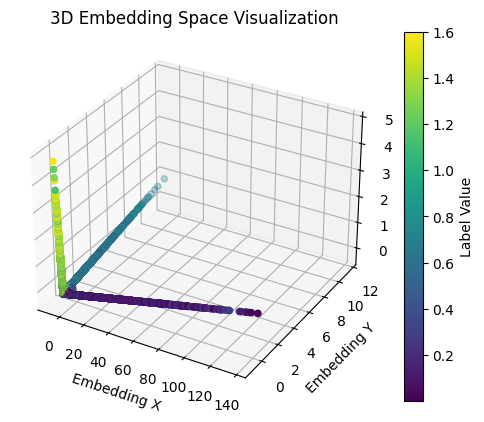

In [23]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Set the model to evaluation mode
model.eval()

# Collect all embeddings and labels
all_embeddings = []
all_labels = []  # Assuming you want to visualize some aspect of your labels

with torch.no_grad():
    for data, targets in loader:
        data = data.to(device)
        embeddings, _ = model(data)  # Make sure to adapt this line if your model returns more than one output
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(targets.cpu().numpy())

# Convert list to numpy array
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Reduce dimensionality to 3 if necessary
if all_embeddings.shape[1] > 3:
    pca = PCA(n_components=3)
    all_embeddings = pca.fit_transform(all_embeddings)

# Visualizing the embeddings
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming you want to color the points by the first label in your label set for simplicity
scatter = ax.scatter(all_embeddings[:, 0], all_embeddings[:, 1], all_embeddings[:, 2], c=all_labels[:, 0], cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Label Value')

ax.set_xlabel('Embedding X')
ax.set_ylabel('Embedding Y')
ax.set_zlabel('Embedding Z')
plt.title('3D Embedding Space Visualization')
plt.show()